## Intro
Build an algorithm to classify whether images contain either a dog or a cat. https://www.kaggle.com/c/dogs-vs-cats

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pickle
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd '/content/drive/My Drive/Kaggle/cats-and-dogs'

Mounted at /content/drive
/content/drive/My Drive/Kaggle/cats-and-dogs


In [ ]:
%%bash
mkdir ./test_data
unzip train.zip
unzip test.zip -d ./test_data

## Sort train images to train and test, cats and dogs folders

In [ ]:
import os

base_dir = './train_test_split'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_cats = os.path.join(train_dir, 'cats')
test_cats = os.path.join(test_dir, 'cats')

train_dogs = os.path.join(train_dir, 'dogs')
test_dogs = os.path.join(test_dir, 'dogs')


In [ ]:
os.mkdir(base_dir)
for path_ in [train_dir, test_dir,
             train_cats, test_cats,
             train_dogs, test_dogs]:
    os.mkdir(path_)

In [ ]:
import shutil

def copyfiles(a,b,c,d): 
  fnames = [a.format(i) for i in range(b,c)]
  for fname in fnames:
    src = os.path.join('./train',fname)
    dst = os.path.join(d, fname)
    shutil.copyfile(src,dst)
    
copyfiles('cat.{}.jpg',0,11000,train_cats)
copyfiles('cat.{}.jpg',11000,12500,test_cats)
copyfiles('dog.{}.jpg',0,11000,train_dogs)
copyfiles('dog.{}.jpg',11000,12500,test_dogs)

## Read in data

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

image_size = 255
batch_size = 64

train_generator = ImageDataGenerator(validation_split=0.2)
train_data = train_generator.flow_from_directory(
    train_dir,
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=50,
    subset="training"
)
validation_data = train_generator.flow_from_directory(
    train_dir,
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=50,
    subset="validation"
)

Found 17600 images belonging to 2 classes.
Found 4400 images belonging to 2 classes.


## Transfer learning

### Add data augmentation

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow import keras

# Hyperparameter ref: https://www.kaggle.com/code/qwertyuioplain/datasc-dogs-vs-cats-transfer-learning-efficientnet#Dataset-batch-processing
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

### Download VGG16 as the base model

In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet',
                  include_top=False
                  )
# Set not to update VGG16 weights
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build model using Sequential api

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dropout
model = Sequential()
model.add(layers.Input(shape=(image_size,image_size,3)))
model.add(img_augmentation)
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# Hyperparameters ref: https://www.kaggle.com/code/arezoodahesh/cats-vs-dogs-augmentation-transfer-learning#3.-Transfer-learning
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=1e-4),
            metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 255, 255, 3)      0         
 l)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                      

In [ ]:
early_stop = keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
save_best = keras.callbacks.ModelCheckpoint(filepath = 'best_model_vgg16.hdf5',
                            verbose=1, 
                            save_best_only=True
)
history = model.fit_generator(
      train_data,
      steps_per_epoch=train_data.samples // batch_size, 
      epochs=10,
      validation_data=validation_data,
      validation_steps=validation_data.samples // batch_size, 
      callbacks=[early_stop, save_best]
)

Epoch 1/10
275/275 [==============================] - ETA: 0s - loss: 0.7699 - accuracy: 0.9507
Epoch 1: val_loss improved from inf to 0.20290, saving model to best_model_vgg16.hdf5
275/275 [==============================] - 1844s 7s/step - loss: 0.7699 - accuracy: 0.9507 - val_loss: 0.2029 - val_accuracy: 0.9623
Epoch 2/10
275/275 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9899
Epoch 2: val_loss did not improve from 0.20290
275/275 [==============================] - 83s 303ms/step - loss: 0.0539 - accuracy: 0.9899 - val_loss: 0.3184 - val_accuracy: 0.9662
Epoch 3/10
275/275 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9977
Epoch 3: val_loss did not improve from 0.20290
275/275 [==============================] - 83s 301ms/step - loss: 0.0172 - accuracy: 0.9977 - val_loss: 0.3675 - val_accuracy: 0.9720
Epoch 4/10
275/275 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9989
Epoch 4: val_loss did not improve f

In [ ]:
test_image_files = os.listdir('./test_data/test')
test_df = pd.DataFrame(data = test_image_files, columns = ['filename'])
test_df['id'] = test_df['filename'].apply(lambda f: int(f.split('.')[0]))
test_df.sort_values(by = 'id', inplace = True, ignore_index = True)

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    './test_data/test', 
    x_col='filename',
    class_mode= None,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
best_model = tf.keras.models.load_model('best_model_vgg16.hdf5')
predict = best_model.predict(test_generator)

196/196 [==============================] - 251s 1s/step


In [ ]:
test_df["label"] = predict
result = test_df[["id", "label"]]
result.to_csv('submission_vgg16_4.csv', index=False)

In [ ]:
result.head()

,id,label
0,1,0.427737
1,2,0.569844
2,3,0.482319
3,4,0.501430
4,5,0.388577


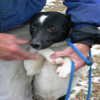

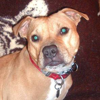

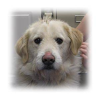

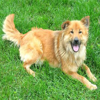

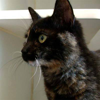

In [ ]:
import PIL
for id in [1,2,3,4,5]:
  filename = './test_data/test/{}.jpg'.format(str(id))
  image = PIL.Image.open(filename)
  image.resize((100,100))
  image.show()